In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# Actor Network
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        action_probs = torch.softmax(self.fc2(x), dim=-1)
        return action_probs

# Critic Network
class CriticNetwork(nn.Module):
    def __init__(self, state_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        value = self.fc2(x)
        return value

# Function to select action based on policy
def select_action(actor, state):
    state = torch.tensor(state, dtype=torch.float32)
    action_probs = actor(state)
    action = np.random.choice(len(action_probs.detach().numpy()), p=action_probs.detach().numpy())
    return action, action_probs[action]

# 贪心策略选择动作
def select_greedy_action(actor, state):
    state = torch.tensor(state, dtype=torch.float32)
    action_probs = actor(state)
    action = torch.argmax(action_probs).item()
    return action, action_probs[action]

def train_actor_critic(env_name="CartPole-v1", 
                       actor_lr=3e-4, 
                       critic_lr=3e-4, 
                       gamma=0.99, 
                       max_episodes=1000, 
                       max_timesteps=500, 
                       success_episodes=5,
                       n_steps=5,
                       lambda_=0.95):
    # Initialize environment
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    print(f"Environment: {env_name}")
    print(f"State space: {state_dim} dimensions")
    print(f"Action space: {action_dim} actions")
    print(f"Reward threshold: {env.spec.reward_threshold}")
    print(f"Maximum episode steps: {env.spec.max_episode_steps}")

    # Initialize networks and optimizers
    actor = ActorNetwork(state_dim, action_dim)
    critic = CriticNetwork(state_dim)
    actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)

    # Training loop
    success_count = 0
    total_rewards = []

    plt.ion()
    fig, ax = plt.subplots()
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    line, = ax.plot([], [], label='Total Reward')
    ax.legend()

    # Parameters for truncated TD(λ)
    weight = 1 - lambda_
    lambdas = [lambda_ ** i for i in range(n_steps + 1)]
    print(f"weights: ", [weight * lambdas[i] if i + 1 < n_steps else weight * lambdas[i] + lambdas[i + 1] for i in range(n_steps)])

    for episode in range(max_episodes):
        state = env.reset()
        total_reward = 0
        
        states = []
        rewards = []

        for t in range(max_timesteps):
            # Select action and observe reward and next state
            action, action_prob = select_action(actor, state)
            next_state, reward, done, _ = env.step(action)

            # Store state and reward
            states.append(state)
            rewards.append(reward)

            if len(states) >= n_steps or done:
                values = [critic(torch.tensor(s, dtype=torch.float32)) for s in states + [next_state]]
                G_ns = []
                R = torch.tensor(0, dtype=torch.float32)
                reward_tensor = torch.tensor(rewards, dtype=torch.float32)
                for n in range(len(rewards)):
                    R += gamma ** n * reward_tensor[n]
                    if n == len(rewards) - 1:
                        G_ns.append(R + gamma ** (n + 1) * values[n + 1] * (1 - int(done)))
                    else:
                        G_ns.append(R + gamma ** (n + 1) * values[n + 1])
                G_lambda = sum([lambdas[i] * G_ns[i] for i in range(len(rewards))]) * weight + G_ns[-1] * lambdas[len(rewards)]

                # Calculate TD Error
                td_error = G_lambda - values[0]

                # Update Actor (Policy Gradient)
                actor_loss = -torch.log(action_prob) * td_error.detach()
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # Update Critic (Value Loss)
                critic_loss = td_error.pow(2)
                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()

                states.pop(0)
                rewards.pop(0)

            # Transition to the next state
            state = next_state
            total_reward += reward

            if done:
                break

        total_rewards.append(total_reward)
        line.set_data(range(len(total_rewards)), total_rewards)
        ax.relim()
        ax.autoscale_view()
        plt.pause(0.05)

        '''if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}, Total Reward: {total_reward}")'''

        # Check for success
        if total_reward >= env.spec.reward_threshold:
            success_count += 1
            current_lr = actor_optimizer.param_groups[0]['lr']
            if success_count >= 5 and current_lr > 1e-4: # 降低学习率
                actor_optimizer.param_groups[0]['lr'] = 1e-4
                critic_optimizer.param_groups[0]['lr'] = 1e-3
                print(f"Lowered learning rate to 1e-4 at episode {episode + 1}")
            if success_count >= success_episodes:
                print(f"Solved after {success_count} consecutive successful episodes!")
                break
        else:
            success_count = 0

    plt.ioff()
    plt.show()
    # 保存模型
    torch.save(actor.state_dict(), env_name + '_actor.pth')
    torch.save(critic.state_dict(), env_name + '_critic.pth')

    return actor, critic, total_rewards

Environment: CartPole-v1
State space: 4 dimensions
Action space: 2 actions
Reward threshold: 475.0
Maximum episode steps: 500
weights:  [0.050000000000000044, 0.04750000000000004, 0.04512500000000004, 0.04286875000000003, 0.8145062499999998]
Lowered learning rate to 1e-4 at episode 167
Solved after 50 consecutive successful episodes!


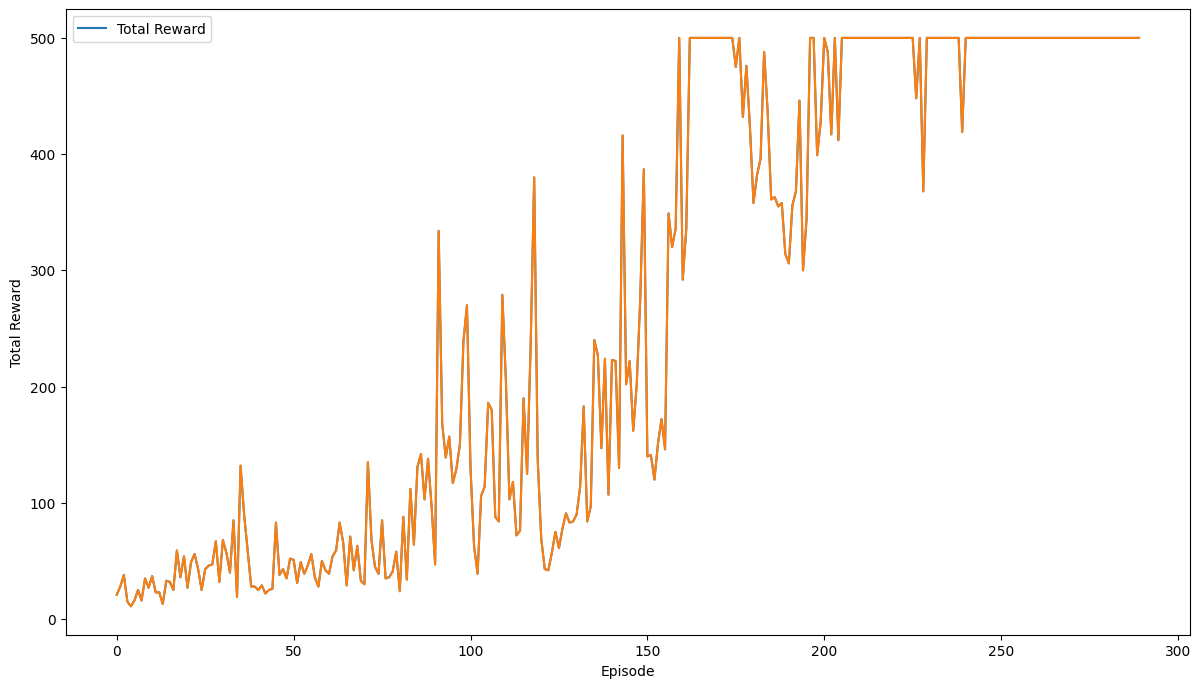

In [2]:
# 在新窗口中显示图像
%matplotlib qt
actor_net, critic_net, total_rewards = train_actor_critic(env_name="CartPole-v1", 
                    actor_lr=1e-3, 
                    critic_lr=1e-2, 
                    gamma=0.99, 
                    max_episodes=1000, 
                    max_timesteps=1000, 
                    success_episodes=50,
                    n_steps=5,
                    lambda_=0.95)
# 重新设置为行内显示
%matplotlib inline
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

In [3]:
import gym
import time
import keyboard

# Test the trained model
def test_actor_critic(env_name="CartPole-v1"):
    
    # Initialize environment
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    print(f"Environment: {env_name}")
    print(f"State space: {state_dim} dimensions")
    print(f"Action space: {action_dim} actions")
    print(f"Reward threshold: {env.spec.reward_threshold}")
    print(f"Maximum episode steps: {env.spec.max_episode_steps}")

    # Initialize networks and optimizers
    actor_net = ActorNetwork(state_dim, action_dim)
    actor_net.load_state_dict(torch.load(env_name + '_actor.pth', weights_only=True)) # 加载训练好的actor网络
    actor_net.eval()
    state = env.reset()
    step = 0

    while True:
        env.render()
        # 帧率控制
        time.sleep(1/30)
        
        # 贪婪策略选择动作
        action, _ = select_greedy_action(actor_net, state)
        state, reward, done, _ = env.step(action)
        step += 1

        if keyboard.is_pressed('esc'):
            print("Exit")
            break

    env.close()
    print(f"Steps: {step}")

test_actor_critic(env_name="CartPole-v1")

Environment: CartPole-v1
State space: 4 dimensions
Action space: 2 actions
Reward threshold: 475.0
Maximum episode steps: 500
Exit
Steps: 154
